<a href="https://colab.research.google.com/github/MagdaPla/UNET_PPM/blob/master/UNET_ppm_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DETECCIÓ DE ZONES AFECTADES PER PROCESSIONÀRIA A PARTIR D'IMATGES DRON I DEEP LEARNING (UNET)

## 1- PREPARACIÓ DE LES DADES I ENTRENAMENT DEL MODEL

In [64]:
# instal·lem els paquets necessaris
system("sudo apt-get update") 
system("sudo apt-get install -y libmagick++-dev")
# des del Google Colab em cal fer el "sudo" per instal·lar alguns
# paquets concrets, ex. magick

install.packages("magick")
install.packages("keras")
install.packages("tfdatasets")
install.packages("tidyverse")
install.packages("rsample")
install.packages("reticulate")
install.packages("tibble")
install.packages("here")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
library(magick)
library(keras)
library(tfdatasets)
library(tidyverse)
library(rsample)
library(reticulate)
library(tibble)
library(here)

In [0]:
set.seed(100) # per a fer el model reproduïble si és necessari

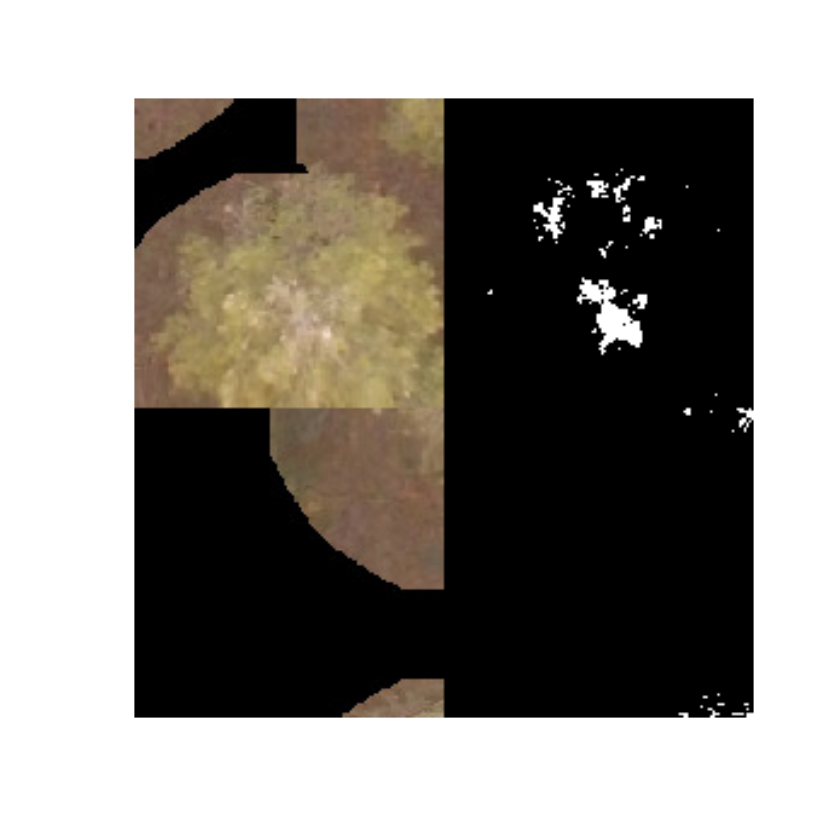

In [67]:
#comencem a carregar les imatges:
images <- tibble(
  img = list.files(here::here("sample_data/rgb"), full.names = TRUE),
  mask = list.files(here::here("sample_data/masc1"), full.names = TRUE)
  ) %>% 
  sample_n(2) %>% 
  map(. %>% magick::image_read())

out <- magick::image_append(c(
  magick::image_append(images$img, stack = TRUE), 
  magick::image_append(images$mask, stack = TRUE)
  )
)
plot(out)  
# en alguns casos les imatges "gif" de les màscares no es visualitzen bé
# malgrat que estan de forma correcte

In [0]:
#Comencem a construïr el model: 
# Utilitzarem `tfdatasets` per a carregar les dades i preparar el "pipeline"

data <- tibble(
  img = list.files(here::here("sample_data/rgb"), full.names = TRUE),
  mask = list.files(here::here("sample_data/masc1"), full.names = TRUE)
)

data <- initial_split(data, prop = 0.8)

In [0]:
#definim el "pipeline" per llegir els fitxers i decodificar les imatges 
# en aquest cas les tenim com a RGB en `.jpeg` i màscares en `.gif`.
# no es sap decodificar els tiff, no existeix decode_tif... així que hem transformat a jpg i gif
training_dataset <- training(data) %>%  
  tensor_slices_dataset()%>% 
  dataset_map(~.x %>% list_modify(
    img = tf$image$decode_jpeg(tf$io$read_file(.x$img)),
    mask = tf$image$decode_gif(tf$io$read_file(.x$mask))[1,,,][,,1,drop=FALSE]
  ))

In [0]:
#per veure els outputs de manera interactiva, utilitzarem:
example <- training_dataset %>% as_iterator() %>% iter_next()

In [0]:
#Carreguem les imatges en un tensor `float32` 
#amb valors entre [0,1]:
training_dataset <- training_dataset %>% 
  dataset_map(~.x %>% list_modify(
    img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32),
    mask = tf$image$convert_image_dtype(.x$mask, dtype = tf$float32)
  ))

In [72]:
summary(training_dataset)

<MapDataset shapes: {img: (None, None, None), mask: (None, None, 1)}, types: {img: tf.float32, mask: tf.float32}>


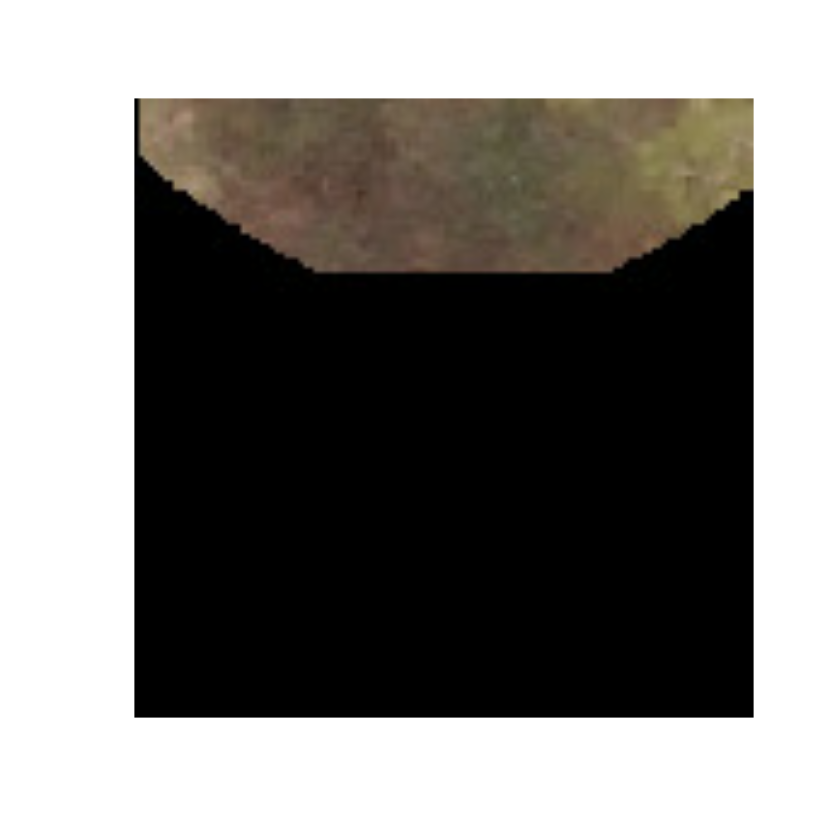

In [73]:
example <- training_dataset %>% as_iterator() %>% iter_next()
example$img %>% as.array() %>% as.raster() %>% plot()

In [0]:
# fem un procés senzill d'"augment" de les imatges
# de canvis de contrast, billantor, saturació 
# he probat flips d'esquerra a dreta i dalt a baix però empitjoren ajust
random_bsh <- function(img) {
  img %>% 
    tf$image$random_brightness(max_delta = 0.3) %>% 
    tf$image$random_contrast(lower = 0.3, upper = 0.7) %>% 
    tf$image$random_saturation(lower = 0.3, upper = 0.7) %>% 
    tf$clip_by_value(0, 1) #%>% # clip the values into [0,1] range.
    #tf$image$random_flip_left_right(seed = 100) %>%
    #tf$image$random_flip_up_down(seed = 123)
}

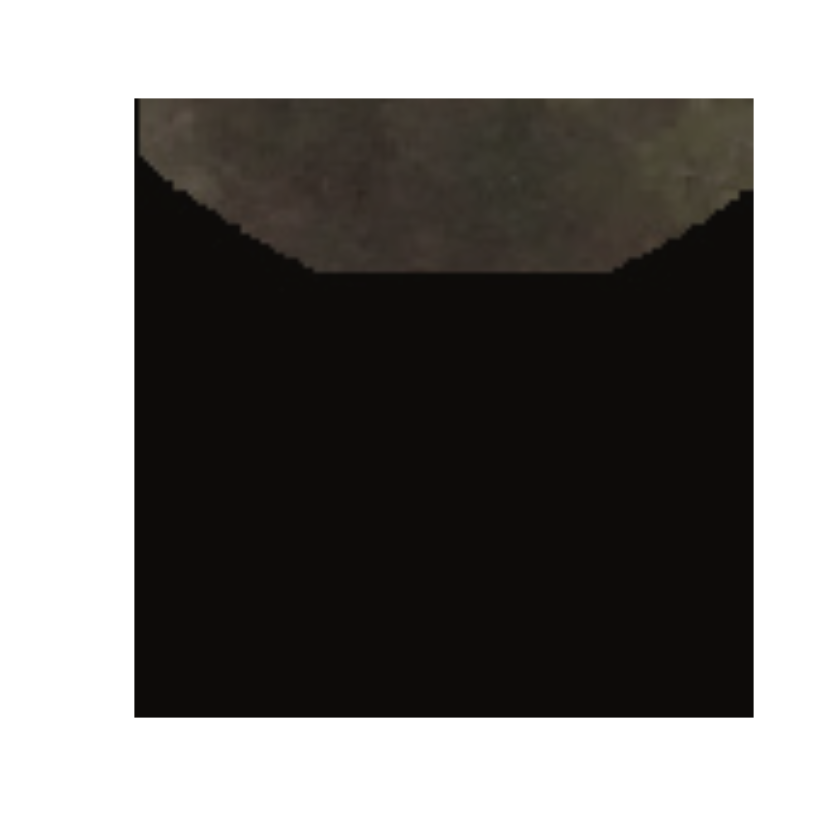

In [75]:
# veiem els efectes sobre les imatges corresponents 
training_dataset <- training_dataset %>% 
  dataset_map(~.x %>% list_modify(
    img = random_bsh(.x$img)
  ))
# plot:
example <- training_dataset %>% as_iterator() %>% iter_next()
example$img %>% as.array() %>% as.raster() %>% plot()

In [0]:
#creem una funció amb tot el codi anterior, a punt per a crear el dataset

create_dataset <- function(data, train, batch_size = 32L) {
  
  dataset <- data %>% 
    tensor_slices_dataset() %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$decode_jpeg(tf$io$read_file(.x$img)),
      mask = tf$image$decode_gif(tf$io$read_file(.x$mask))[1,,,][,,1,drop=FALSE]
    )) %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32),
      mask = tf$image$convert_image_dtype(.x$mask, dtype = tf$float32)
    ))
  
  if (train) {
    dataset <- dataset %>% 
      dataset_map(~.x %>% list_modify(
        img = random_bsh(.x$img)
      )) 
  }
  
  if (train) {
    dataset <- dataset %>% 
      dataset_shuffle(buffer_size = batch_size*128)
  }
  
  dataset <- dataset %>% 
    dataset_batch(batch_size)
    
  dataset %>% 
    dataset_map(unname) # Keras needs an unnamed output.
}

In [0]:
# Creem propiament les dades d'entrenament i les de validacióa partir del dataset:
training_dataset <- create_dataset(training(data), train = TRUE)
validation_dataset <- create_dataset(testing(data), train = FALSE)

In [0]:
# a dalt hem preparat el "pipeline" a continuació definim 
# la mètrica i "loss" de manera personalitzada: 
# mirar però si em convé més utilitzar "binari crosentropy" o aquest... valoro

dice_coef <- custom_metric("custom", function(y_true, y_pred, smooth = 1.0) {
  y_true_f <- k_flatten(y_true)
  y_pred_f <- k_flatten(y_pred)
  intersection <- k_sum(y_true_f * y_pred_f)
  result <- (2 * intersection + smooth) / 
    (k_sum(y_true_f) + k_sum(y_pred_f) + smooth)
  return(result)
})

# per calcular el paràmetre "loss" segons Wagner et al,
# valoro si cal posar-la o no, de moment he utilitzat la BinaryCrossentropy
 bce_dice_loss <- function(y_true, y_pred) {
  result <- loss_binary_crossentropy(y_true, y_pred) +
    (1 - dice_coef(y_true, y_pred))
  return(result)
}

In [79]:
# el model i la seva compilació: 
model <- keras_model_sequential()

get_unet_128 <- function(input_shape = c(128, 128, 3),
                         num_classes = 1) {
  
  inputs <- layer_input(shape = input_shape)
  # 128
  
  down1 <- inputs %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down1_pool <- down1 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 64
  
  down2 <- down1_pool %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down2_pool <- down2 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 32
  
  down3 <- down2_pool %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down3_pool <- down3 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 16
  
  down4 <- down3_pool %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down4_pool <- down4 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 8
  
  center <- down4_pool %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  # center
  
  up4 <- center %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down4, .), axis = 3)} %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 16
  
  up3 <- up4 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down3, .), axis = 3)} %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 32
  
  up2 <- up3 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down2, .), axis = 3)} %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 64
  
  up1 <- up2 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down1, .), axis = 3)} %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 128
  
  classify <- layer_conv_2d(up1,
                            filters = num_classes, 
                            kernel_size = c(1, 1),
                            activation = "sigmoid")
  
  
  model <- keras_model(
    inputs = inputs,
    outputs = classify
  )
  
  model %>% compile(
    optimizer = optimizer_rmsprop(lr = 0.0001),
    loss = "BinaryCrossentropy",#bce_dice_loss, 
    metrics = c(dice_coef)
  )
  
  return(model)
}

model <- get_unet_128()
summary(model)

Model: "model_1"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_2 (InputLayer)      [(None, 128, 128, 0                                   
________________________________________________________________________________
conv2d_23 (Conv2D)        (None, 128, 128,  1792     input_2[0][0]              
________________________________________________________________________________
batch_normalization_22 (B (None, 128, 128,  256      conv2d_23[0][0]            
________________________________________________________________________________
activation_22 (Activation (None, 128, 128,  0        batch_normalization_22[0][0
________________________________________________________________________________
conv2d_24 (Conv2D)        (None, 128, 128,  36928    activation_22[0][0]        
________________________________________________________________________________
batch_norma

In [0]:
# creem un callbacks per emmagatzemar informació
# que ens pot ser útil per a repetir el model
# fer prediccions, etc.
checkpoint_path <- "weights_r/cp.ckpt"

# Create checkpoint callback
cp_callback <- callback_model_checkpoint(
  filepath = checkpoint_path,
  save_weights_only = TRUE,
  save_best_only = TRUE,
  verbose = 1
)

In [0]:
#i ajustem el model amb les dades d'entrenament: 
history <- model %>% fit(
  training_dataset,
  epochs = 100,
  validation_data = validation_dataset, 
  callbacks = list(cp_callback), # pass callback to training,
  verbose= 2
)


`geom_smooth()` using formula 'y ~ x'



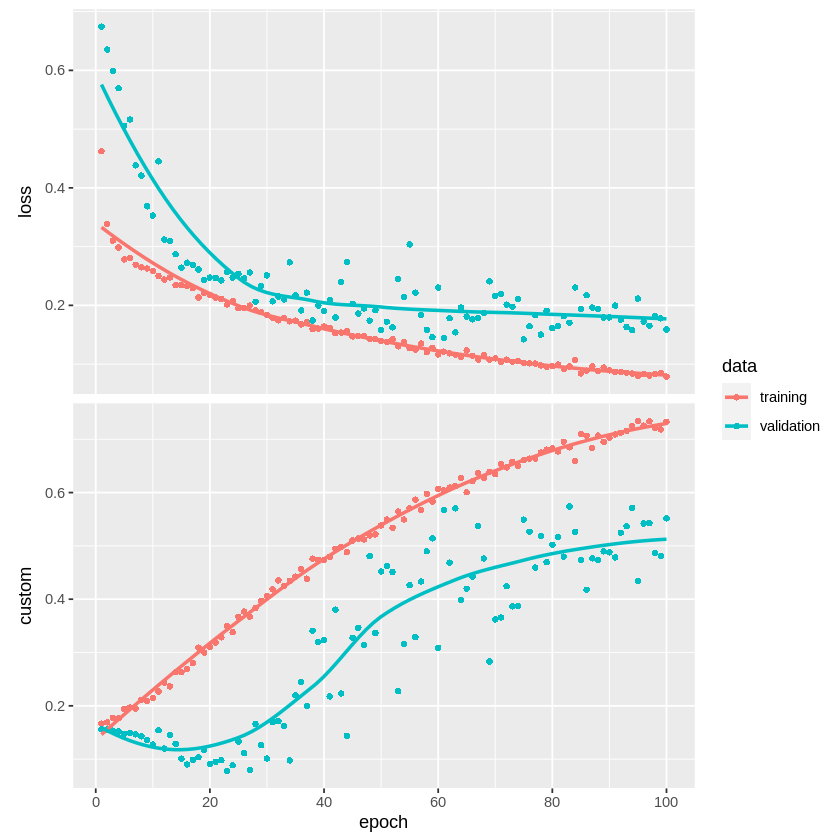

In [82]:
# veiem gràficament els ajustos de l'entrenament
plot(history)

In [83]:
print(history)


Final epoch (plot to see history):
      loss: 0.07861
    custom: 0.7325
  val_loss: 0.1589
val_custom: 0.5516 


In [84]:
# evaluem la bondat de l'ajust per les dades de validació
accuracy <- model %>% evaluate(validation_dataset,verbose = 0)
print(accuracy)

     loss    custom 
0.1588881 0.5515674 


## 2. Una validació inicial (i visual) de model

In [0]:
# fem les prediccions per les dades de validació
# i visualitzem els resultats 
pred_val <- validation_dataset %>% as_iterator() %>% iter_next()
predictions <- predict(model, pred_val)
#predictions <- model %>% predict(validation_dataset,verbose = 0)

In [86]:
dim(predictions)

[1]  32 128 128   1

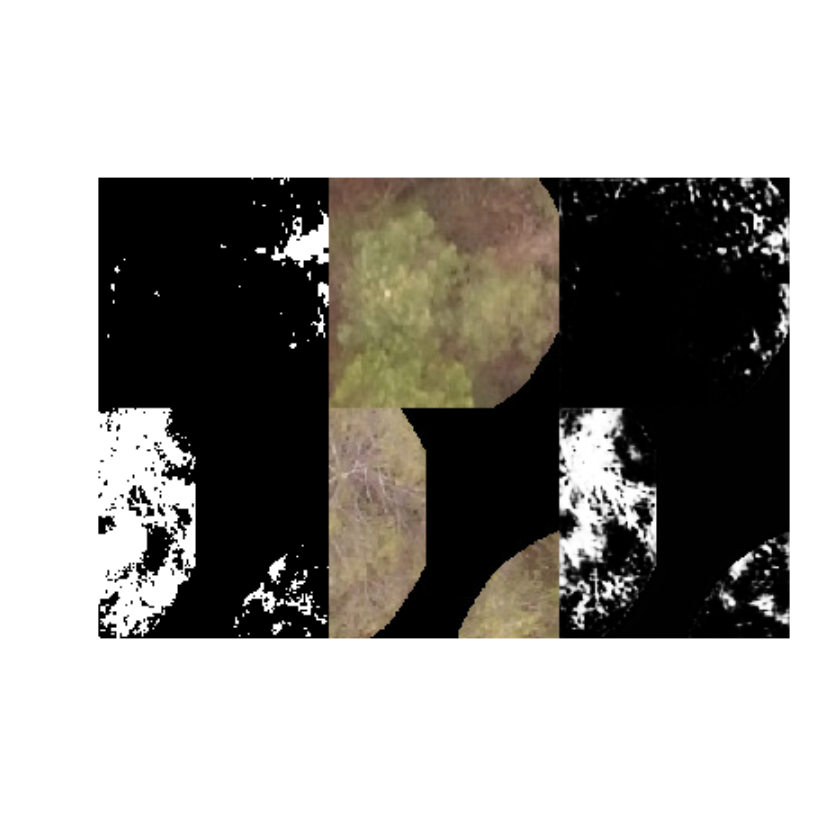

In [99]:
# encara que una nova manera de simbolitzar-ho
images <- tibble(
  image = pred_val[[1]] %>% array_branch(1),
  predicted_mask = predictions[,,,1] %>% array_branch(1),
  mask = pred_val[[2]][,,,1]  %>% array_branch(1)
) %>% 
  sample_n(2) %>% 
  map_depth(2, function(x) {
    as.raster(x) %>% magick::image_read()
  }) %>% 
  map(~do.call(c, .x))


out <- magick::image_append(c(
  magick::image_append(images$mask, stack = TRUE),
  magick::image_append(images$image, stack = TRUE), 
  magick::image_append(images$predicted_mask, stack = TRUE)
  )
)

plot(out)

# **PREDICCIONS A PARTIR DE NOVES DADES**

In [0]:
# Entrem les noves dades a predir de la mateixa manera que hem pujat les dades anteriors
data_p <- tibble(
  img = list.files(here::here("sample_data/kkk"), full.names = TRUE))

data_p <- initial_split(data_p, prop = 0.99)

In [101]:
data_p

<Analysis/Assess/Total>
<141/1/142>

In [0]:
testing_dataset <- training(data_p) %>%  
  tensor_slices_dataset() %>% 
  dataset_map(~.x %>% list_modify(
    img = tf$image$decode_jpeg(tf$io$read_file(.x$img))
  ))

In [0]:
testing_dataset <- testing_dataset %>% 
  dataset_map(~.x %>% list_modify(
    img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32)
  ))

In [0]:
create_dataset <- function(data, train, batch_size = 32L) {
  
  dataset <- data %>% 
    tensor_slices_dataset() %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$decode_jpeg(tf$io$read_file(.x$img))
    )) %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32)
    ))
  
  if (train) {
    dataset <- dataset %>% 
      dataset_map(~.x %>% list_modify(
        img = random_bsh(.x$img)
      )) 
  }
  
  if (train) {
    dataset <- dataset %>% 
      dataset_shuffle(buffer_size = batch_size*128)
  }
  
  dataset <- dataset %>% 
    dataset_batch(batch_size)
  
  
  
  dataset %>% 
    dataset_map(unname) # Keras needs an unnamed output.
}

In [0]:
testing_dataset <- create_dataset(training(data_p), train = TRUE)
#validation_dataset <- create_dataset(testing(data), train = FALSE)

In [0]:
new_pred <- testing_dataset %>% as_iterator() %>% iter_next()
new_predictions <- predict(model, new_pred)

In [113]:
dim(new_predictions)

[1]  32 128 128   1

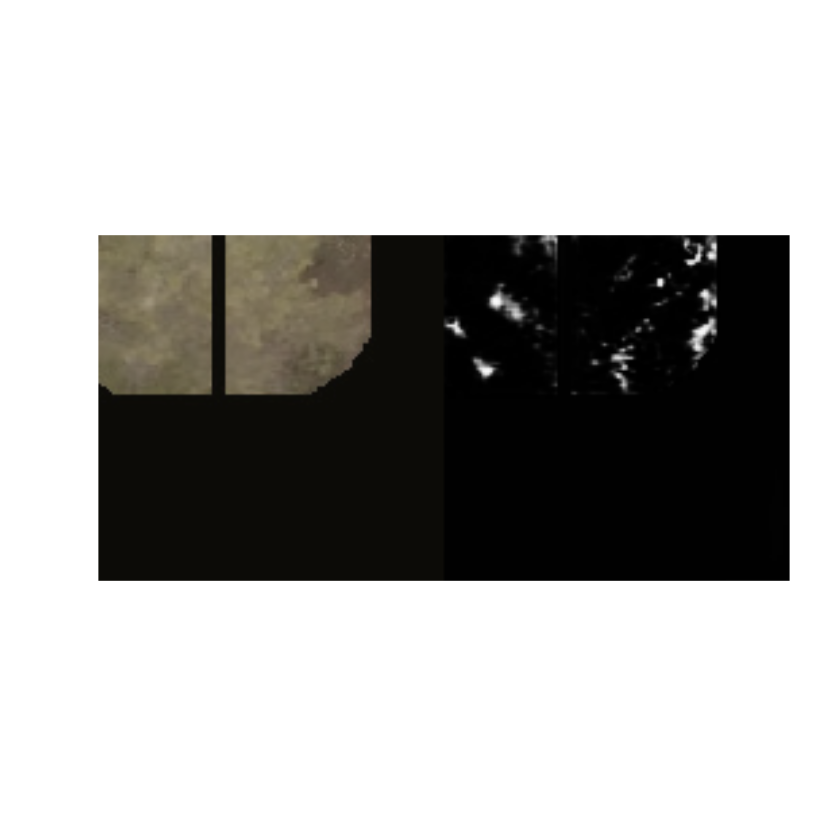

In [130]:
# encara que una nova manera de simbolitzar-ho
images <- tibble(
  image = new_pred[[1]] %>% array_branch(1),
  predicted_mask = new_predictions[,,,1] %>% array_branch(1)
) %>% 
  sample_n(1) %>% 
  map_depth(2, function(x) {
    as.raster(x) %>% magick::image_read()
  }) %>% 
  map(~do.call(c, .x))


out <- magick::image_append(c(
  magick::image_append(images$image, stack = TRUE), 
  magick::image_append(images$predicted_mask, stack = TRUE)
  )
)
plot(out)

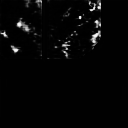

# A tibble: 1 x 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      128    128 sRGB       TRUE         0 72x72  

In [141]:
images$predicted_mask

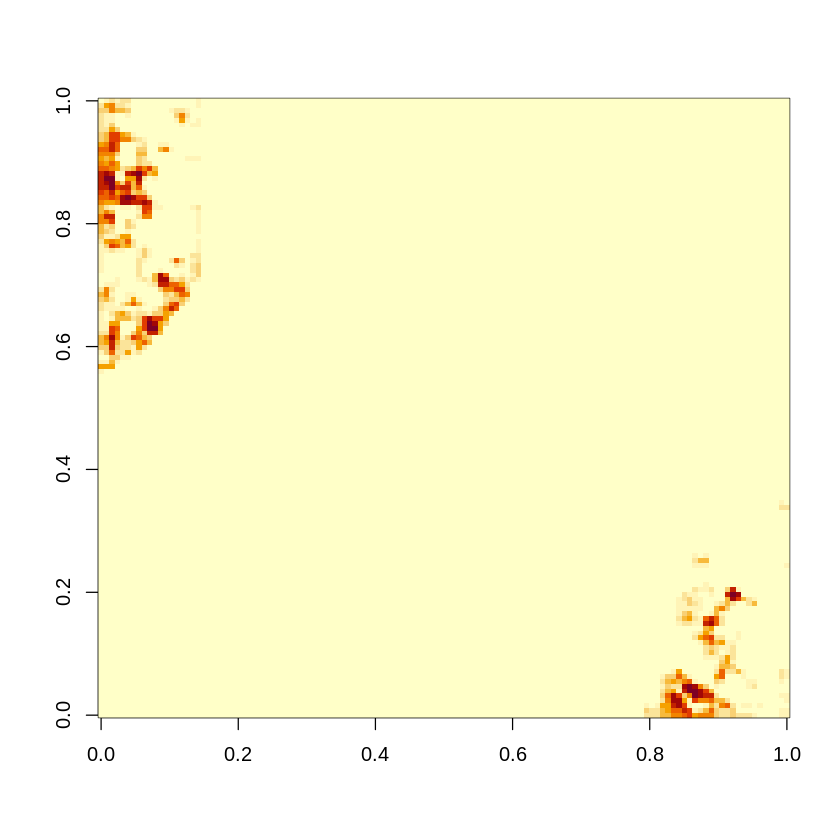

In [159]:
image(t(new_predictions[32, , ,1 ]))

In [182]:
install.packages("raster")


system("sudo apt-get update")
system("sudo apt-get install libgdal-dev libproj-dev")

install.packages("rgdal")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [183]:
library(raster)
library(rgdal)

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


The following object is masked from ‘package:tidyr’:

    extract


rgdal: version: 1.5-8, (SVN revision 990)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
Path to GDAL shared files: /usr/share/gdal/2.2
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
Path to PROJ shared files: (autodetected)
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.



In [0]:
# la info original RGB
#img <- list.files(here::here("sample_data/rgb1"), full.names = TRUE)
img=brick(list.files(here::here("sample_data/kkk"),full.names = TRUE)[[32]])  

In [0]:
# exemple de com guardar una de les imatges predites
img_array<-array(data=NA, dim = c(128,128,1), dimnames = NULL)

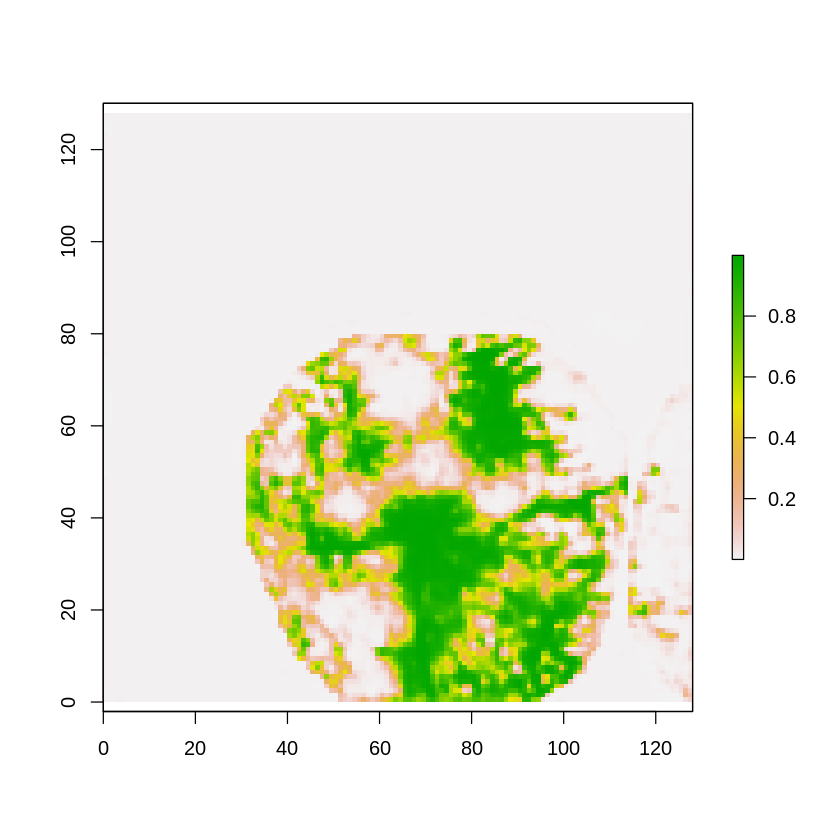

In [211]:
# els resultats de les prediccions tenen un valor de 0 a 1 de probabilitat
# de ser dany de processionària
# podem generar una capa ja amb la sel·lecció feta si considerem que
# són vàlids els valors de dany >0.5

#img_array[,,1]=as.matrix(ifelse(t(new_predictions[15, , ,1 ]) < 0.5, 0, 1))
img_array[,,1]=as.matrix(t(new_predictions[15, , ,1 ]))
im_pred<-img[[1]]*0
im_pred[]<-img_array[,,1]
plot(im_pred)

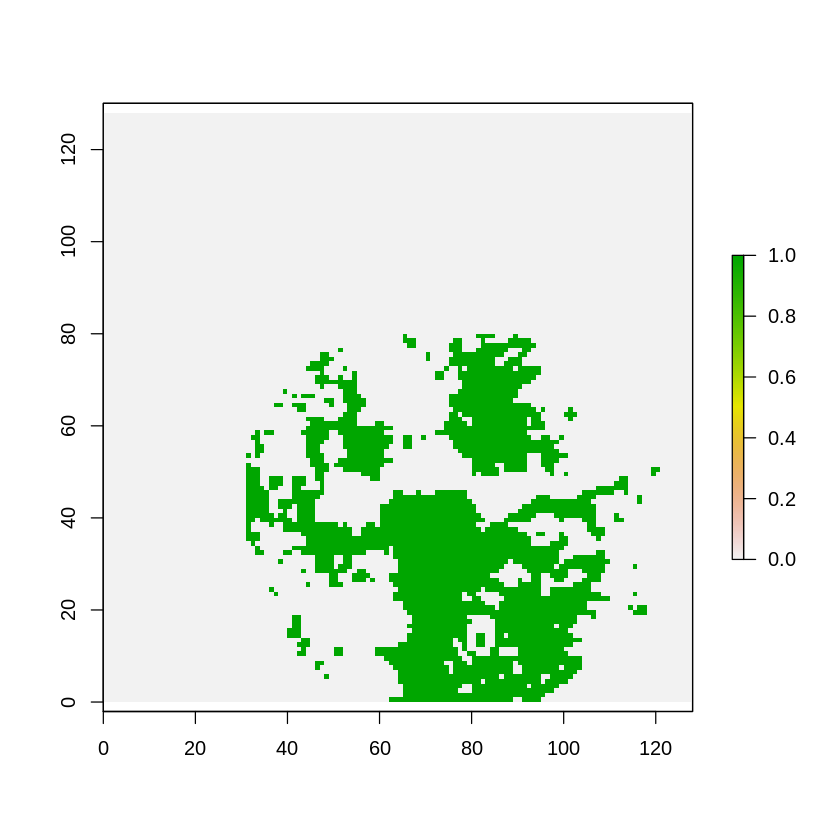

In [214]:
# els resultats de les prediccions tenen un valor de 0 a 1 de probabilitat
# de ser dany de processionària
# podem generar una capa ja amb la sel·lecció feta si considerem que
# són vàlids els valors de dany >0.5

img_array[,,1]=as.matrix(ifelse(t(new_predictions[15, , ,1 ]) < 0.5, 0, 1))
im_pred<-img[[1]]*0
im_pred[]<-img_array[,,1]
plot(im_pred)

In [0]:
# exemple de com guardar una de les imatges predites
raster1<- image_read(img_array)
image_write(raster,path = "sample_data/res/15.tif", format = "tif")

In [0]:

for (i in 1:32) {
  img_array[,,1]=as.matrix(ifelse(t(new_predictions[i, , ,1 ]) < 0.5, 0, 1))
  im_pred<-img[[1]]*0
  im_pred[]<-img_array[,,1]
  raster<- image_read(img_array)
  magick::image_write(raster,path = paste("sample_data/res/",i,".tif", sep = ""), format = "tif")
}